In [1]:
%%capture 
    #Suppresses output
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -u -p /usr/local 
import os
if os.path.isdir('/content/anaconda'): root_path = '/content/anaconda'
else: root_path = '/usr/local/'
os.environ['PATH'] += f":{root_path}/bin"
!conda create -n mp -c conda-forge pymeep python=3.7 -y
print(">> ", root_path)
import sys
sys.path.append(f'{root_path}envs/mp/lib/python3.7/site-packages/')

# Meep installation, as the packages are updated there might be problems

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats


import meep as mp

# This might be worth checking out in the future for better fitting
#from lmfit import minimize, Parameters
#from lmfit.models import StepModel, ConstantModel

plt.rc('font', size=19)          # controls default text sizes

In [3]:
# DBR parameters

if(1):    # Chooses to fix widthDBR
    n1, n2, widthDBR, N_high = [3.5, 2.1, 15, 7]
        # Good choices of numbers:
            # [3.5, 1.7, 30, 20]   # Monstruous rejection ratio, can vary n2
            # [3.5, 2.1, 15, 7]    # Good transmittance with defect, low rejection ratio
        # "1" is higher index
        # widthDBR and N_high are ideally infinite, they increase rejection ratio


    """Need n1d1=n2d2, d1*N_high + d2*(N_high+1) = widthDBR
    Solve the system to get"""
    w2 = widthDBR/(N_high*(n2/n1+1)+1)
    w1 = n2/n1*w2
    a = w1 + w2
    
else: # Chooses to fix a
    n1, n2, a, N_high = [3.5, 1.7, 4, 7]
    w2 = n1/(n1+n2)*a
    w1 = n2/n1*w2
    widthDBR = w1*N_high + w2*(N_high+1)

freqM=(n1+n2)/(4*n1*n2)/a
dfreqM = freqM*4/np.pi*np.arcsin(np.abs(n1-n2)/(n1+n2))
freqM, dfreqM, w1, w2

(0.09682539682539683,
 0.031150908054381848,
 0.7377049180327867,
 1.2295081967213113)

In [4]:
# Adjust simulation parameters
cell_width = widthDBR + 10
cell = mp.Vector3(cell_width,5,0)
pml_layers = [mp.PML(1.0)]
resolution = 10

# Source (and detector)
fcen = freqM    # Could choose other numbers too se higher modes
df = dfreqM*2
nfreq = 100

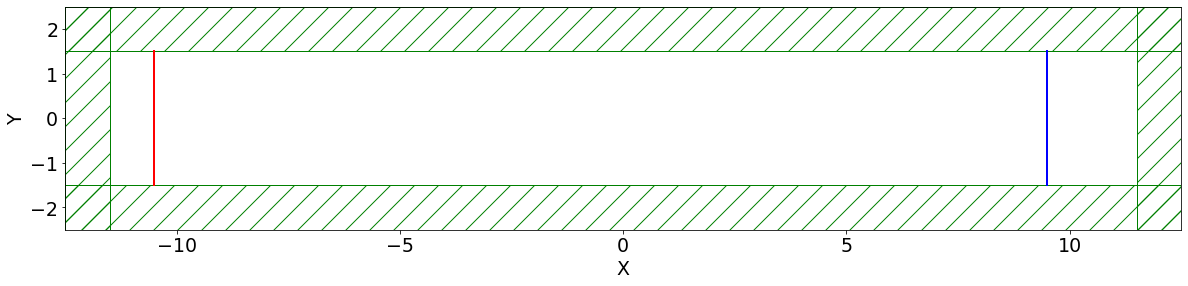

In [10]:
# Choose mode of execution
normalization = 1
defect = 1

try:
    sim.reset_meep()
except NameError:
    pass

# Materials
geometry=[
    # First material, low n
    mp.Block(
        mp.Vector3(widthDBR,mp.inf,mp.inf),
        center = mp.Vector3(0,0,0),
        material = mp.Medium(epsilon=n2**2)
    )
]

# Add other material using a loop
for i in range(0,N_high):
    geometry.append(mp.Block(
        mp.Vector3(w1,mp.inf,mp.inf),
        center = mp.Vector3(w2+(w1+w2)*i+w1/2-widthDBR/2,0,0),
        material = mp.Medium(epsilon=n1**2)
    ))

if(defect):
    geometry.append(mp.Block(
        mp.Vector3(w1*2.1,mp.inf,mp.inf),
        center = mp.Vector3(0,0,0),
        material = mp.Medium(epsilon=n1**2)
    ))

if(normalization):
    geometry = []

# Source
source = [mp.Source(
    mp.GaussianSource(fcen, fwidth=df),
    component = mp.Ez,
    center = mp.Vector3(-cell_width/2+2,0,0),
    size = mp.Vector3(0., 3, 0.)
)]

# Simulation
sim = mp.Simulation(
	  cell_size=cell,
	  boundary_layers = pml_layers,
	  geometry = geometry,
	  sources = source,
	  resolution = resolution
)

# Detector
trans_fr = mp.FluxRegion(
    center = mp.Vector3(cell_width/2-3,0,0),
    size = mp.Vector3(0,3,0)
)
tran = sim.add_flux(fcen, df, nfreq, trans_fr)

fig = plt.figure(figsize=[20,20])
sim.plot2D()
#sim.plot2D(labels=True)
#plt.savefig("DBRsimplot.svg", format = "svg", bbox_inches='tight')
plt.show()

In [11]:
#sim.run(until = 100)

# Pile-up lasts quite a while, need to wait until fields finish going through
pt = mp.Vector3(widthDBR/2-w2/4,0.5,0)
sim.run( until_after_sources=mp.stop_when_fields_decayed(100,mp.Ez,pt,1e-3) )


-----------
Initializing structure...
time for choose_chunkdivision = 0.0002141 s
Working in 2D dimensions.
Computational cell is 25 x 5 x 0 with resolution 10
time for set_epsilon = 0.0214469 s
-----------
field decay(t = 100.05000000000001): 0.012152907947092338 / 0.012152907947092338 = 1.0
field decay(t = 200.10000000000002): 0.011546016112305614 / 0.012152907947092338 = 0.9500620067699989
field decay(t = 300.15000000000003): 2.2037153391110356e-12 / 0.012152907947092338 = 1.8133234849674713e-10
run 0 finished at t = 300.15000000000003 (6003 timesteps)


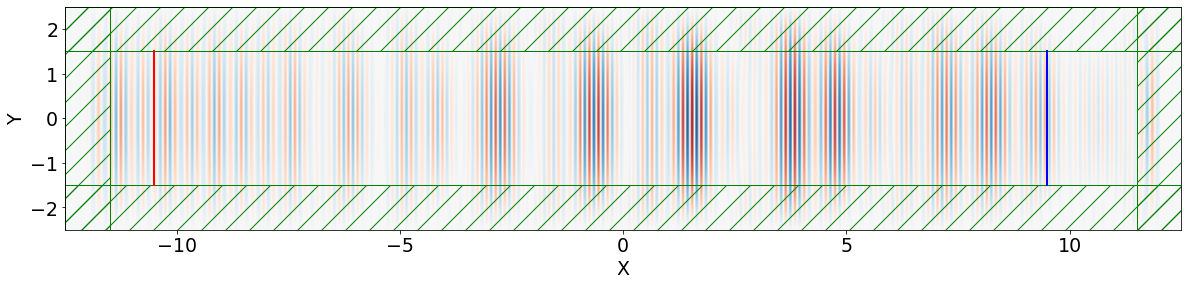

Remaining E field in simulation =  1.7097004908065855e-11


In [12]:
# Make a plot of the electric field at the end of the simulation
ez_data = sim.get_array(size=cell, center=mp.Vector3(), component=mp.Ez)

fig = plt.figure(figsize=[20,20])
ax = plt.axes()
sim.plot2D(fields=mp.Ez)
plt.show()

print("Remaining E field in simulation = ", np.sum(ez_data**2))
# Note that full-field is in the hundreds of units of energy

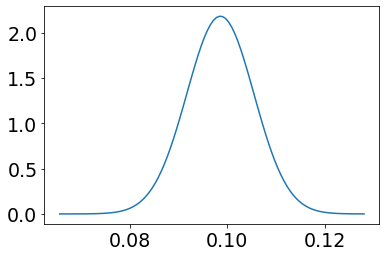

In [13]:
# Save the fluxes, both normalization and not normalization separatedly
freqs = np.array(mp.get_flux_freqs(tran))
if(normalization):
    meas_flux0 = mp.get_fluxes(tran)
    plt.plot(freqs,meas_flux0)
else:
    meas_flux1 = mp.get_fluxes(tran)
    plt.plot(freqs,meas_flux1)
    

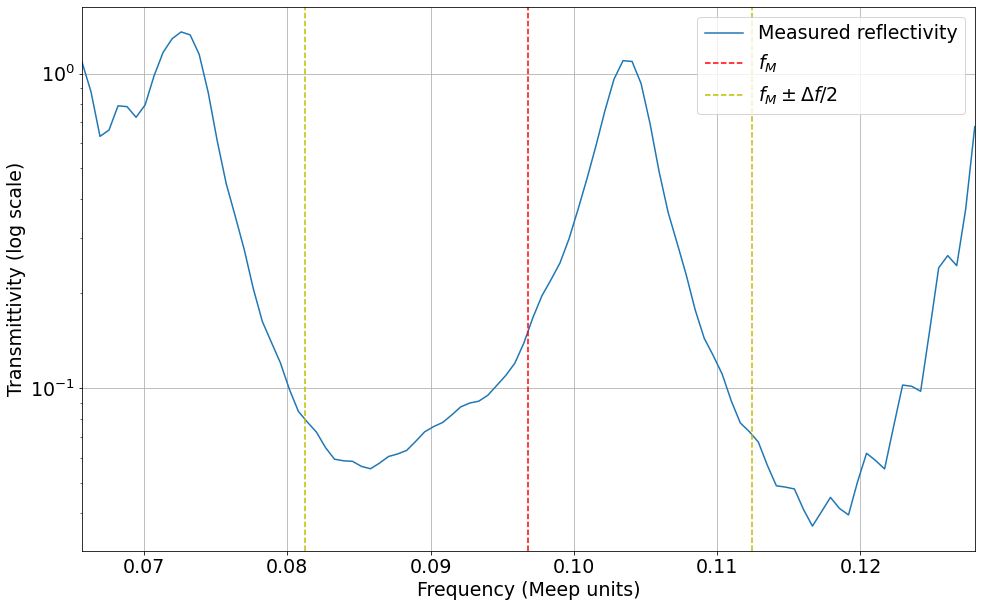

In [17]:
## Plot the ratio
R = np.array(meas_flux1)/np.array(meas_flux0)
plt.figure(figsize=[16,10])
ax = plt.axes()
plt.plot(freqs, R, label = "Measured reflectivity")
ax.axvline(x = freqM, ls = "--", color="r", label = r"$f_M$")
ax.axvline(x = (freqM+dfreqM/2), ls = "--", color="y")
ax.axvline(x = (freqM-dfreqM/2), ls = "--", color="y", label = r"$f_M\pm \Delta f/2$")
plt.xlim(np.min(freqs), np.max(freqs))
plt.grid()
plt.xlabel("Frequency (Meep units)")
plt.ylabel("Transmittivity (log scale)")
plt.legend()
plt.yscale("log")
#plt.savefig("DBRTransmittivity.svg", bbox_inches='tight')
plt.savefig("DBRDefected.svg", bbox_inches='tight')

So, the fundamental value is present. I can also see higher order values. The reflectivity isn't exactly 1 due to the finiteness of the DBR (or maybe also geometrical effect of vacuum).

The sharpness of the walls of our wall gap is dependent on the resolution of the problem. This is especially important at higher frequencies/lower wavelengths.

The fast oscillations arise due to finiteness of the layers of DBR. Interestingly, this is also a problem in commercial devices. This is circumvented by progressively modulating the layer widths (easier) or the indexes of refraction (harder).

In [ ]:
# Compute logarithmic derivative and find the maximum and minimum
logDer = (np.log(R)[2:]-np.log(R)[:-2])/(freqs[1]-freqs[0])

maxFreq = freqs[np.argmax(logDer)+2]
minFreq = freqs[np.argmin(logDer)+2]

freqM_meas = (maxFreq+minFreq)/2
dfreqM_meas = (maxFreq-minFreq)

print(n2)
print(freqM)
print(dfreqM)
print(freqM_meas)
print(dfreqM_meas)

(freqM_meas-freqM)/freqM, (dfreqM_meas-dfreqM)/dfreqM

1.2
0.19345238095238096
0.12595313413050546
0.19472463483248706
0.1221363724901871


(0.006576573903317686, -0.03030303030303037)

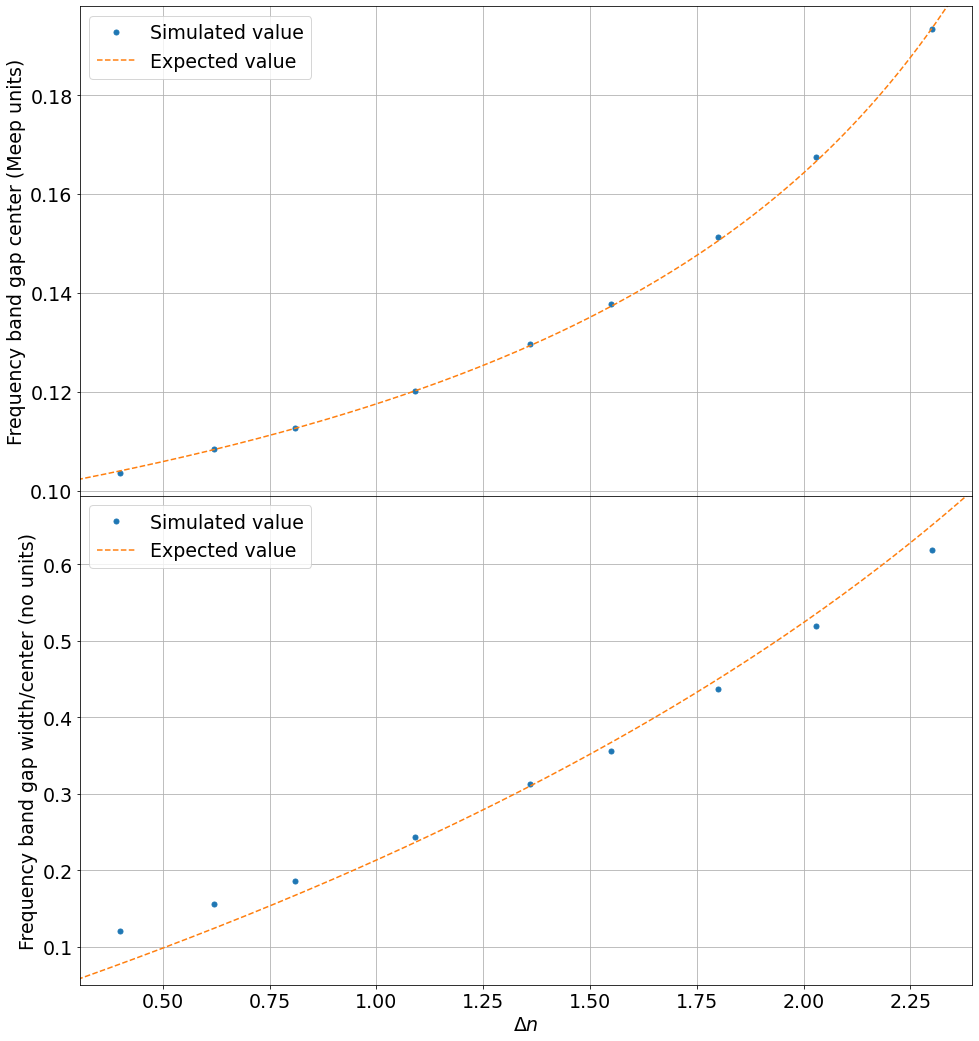

In [ ]:
# Register the measured values to make a plot later
n2_nom =      np.array([1.2    , 1.47   , 1.7    , 1.95   , 2.14   , 2.41   , 2.69   , 2.88   , 3.1    ])
# Nominal frequencies listed here are recalculated later
freqM_nomA =   np.array([0.19345, 0.16667, 0.15056, 0.13736, 0.12939, 0.12023, 0.11267, 0.10838, 0.10407])
dfreqM_nomA =  np.array([0.12595, 0.08929, 0.06775, 0.05044, 0.04012, 0.02839, 0.01882, 0.01343, 0.00803])
freqM_vals =  np.array([0.19345, 0.16757, 0.15124, 0.13787, 0.12980, 0.12023, 0.11267, 0.10851, 0.10358])
dfreqM_vals = np.array([0.11959, 0.08658, 0.06570, 0.04891, 0.04052, 0.02926, 0.02092, 0.01682, 0.01250])

delta_n = 3.5-n2_nom

# Generate theoretical graphs
def nomVals(deltan):
    # Function that implements the equations above
    # Now only based on delta n, to give a theoretical values
    n1 = 3.5
    n2 = n1-deltan

    w2 = widthDBR/(N_high*(n2/n1+1)+1)
    w1 = n2/n1*w2
    a = w1 + w2

    freqM=(n1+n2)/(4*n1*n2)/a
    dfreqM = freqM*4/np.pi*np.arcsin(np.abs(n1-n2)/(n1+n2))
    return freqM, dfreqM
delta_n_linspace = np.linspace(0.3, 2.5, 200)
freqM_nom = np.array([nomVals(dn) for dn in delta_n_linspace])
dfreqM_nom = freqM_nom[:,1]
freqM_nom = freqM_nom[:,0]

## Plot
fig, ax = plt.subplots(2,1, sharex=True, figsize=[16,18])
plt.subplots_adjust(hspace=.0)

ax[0].plot(delta_n, freqM_vals,
         marker = ".", ls = " ", markersize = 10,
         label = "Simulated value"
         )
plt.xlim(*ax[0].get_xlim())
plt.xlabel(r"$\Delta n$")

ax[0].set_ylim(*ax[0].get_ylim())
ax[0].plot(delta_n_linspace, freqM_nom,
         ls = "--",
         label = "Expected value"
         )
ax[0].grid()
ax[0].set_ylabel("Frequency band gap center (Meep units)")
ax[0].legend()


ax[1].plot(delta_n, dfreqM_vals/freqM_nom,
         marker = ".", ls = " ", markersize = 10,
         label = "Simulated value"
         )

#ax[1].set_ylim(*ax[1].get_ylim())
ax[1].set_ylim(0.05, 0.69)
ax[1].plot(delta_n_linspace, dfreqM_nom/freqM_nom,
         ls = "--",
         label = "Expected value"
         )

ax[1].grid()
ax[1].set_ylabel("Frequency band gap width/center (no units)")
ax[1].legend()

plt.savefig("DBRBandGaps.svg", format = "svg", bbox_inches='tight')

# Fitting to get a shape of the hole
Works quite poorly due to the weird shape of the hole

In [ ]:
# Square box
# model= lambda freq, x0, deltax, a, b: np.array([a*(np.abs(x-x0)>deltax/2)+b for x in freq])
    # x0    is the center of the band gap
    # deltax  is the width of the band gap
# Problem: least squares encounters values unaffected by the choice of deltax,
# x0 and just doesn't change them, then exits
    # This is probably due to the fact that they are changed so little when computed

def model(freq, bottom, top, cutoff1, cutoff2, cutoff3, cutoff4):
    # Model that has a well connected with lines on both sides
    out = np.ones(len(freq))
    for idx, i in enumerate(freq):
        # Need 5 regions
        if(i<cutoff1 or i>cutoff4):
            out[idx]=top
        elif(i<cutoff2):
            out[idx]=top-(top-bottom)/(cutoff2-cutoff1)*(i-cutoff1)
        elif(i<cutoff3):
            out[idx]=bottom
        else:
            out[idx]=bottom+(top-bottom)/(cutoff4-cutoff3)*(i-cutoff3)
    return out
# This model fits extremely well without much trouble
    # Sadly, the estimation is far from perfect
    # The suggestion by Gregorio of just lowering the sampling frequency and computing derivatives should be more useful


fit=scipy.optimize.curve_fit(
    model,
    #freqs, R,     #Using R with proper weighing doesn't converge at all
    freqs, np.log10(R), 
    method = 'dogbox',
    p0 = [-6, 0, freqM-dfreqM/2, freqM-dfreqM/4, freqM+dfreqM/4, freqM+dfreqM/2],
    #sigma = 1/R    # Log weighing
    #diff_step = 5*(freqs[1]-freqs[0])     # Works but not sure how it works
                    # Quite inconsistent
    )

fit

(array([-7.73913172, -0.15313225,  0.11091696,  0.12932495,  0.16145545,
         0.18990566]),
 array([[ 1.49322696e-03, -1.51014684e-17,  2.49517462e-15,
         -3.62342812e-06,  5.60013192e-06, -1.08290222e-14],
        [-1.51014684e-17,  8.43065937e-04, -2.04575992e-06,
         -8.62063039e-14,  1.56730297e-14,  3.16180013e-06],
        [ 2.49517462e-15, -2.04575992e-06,  6.59284418e-08,
         -3.02299561e-08, -2.86740372e-17, -7.67233463e-09],
        [-3.62342812e-06, -8.62063039e-14, -3.02299561e-08,
          6.93195764e-08, -1.35891436e-08, -2.97027309e-16],
        [ 5.60013192e-06,  1.56730297e-14, -2.86740372e-17,
         -1.35891436e-08,  1.15103007e-07, -4.68853220e-08],
        [-1.08290222e-14,  3.16180013e-06, -7.67233463e-09,
         -2.97027309e-16, -4.68853220e-08,  1.05939282e-07]]))

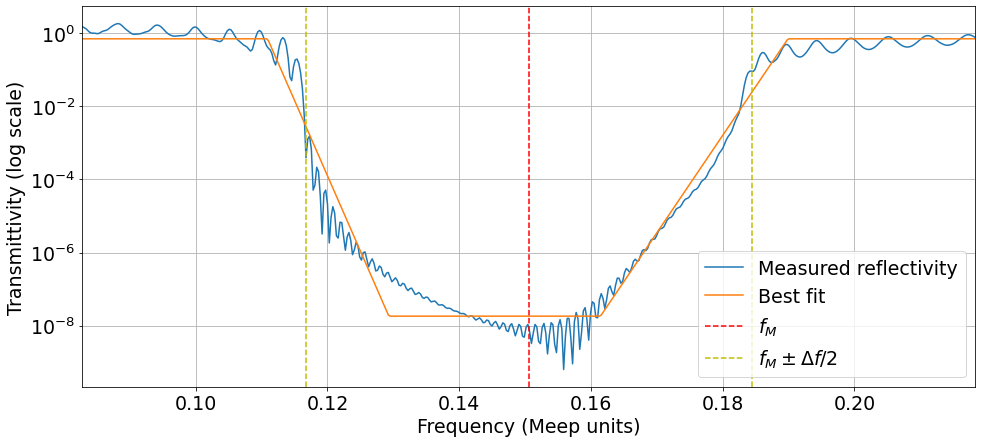

In [ ]:
plt.figure(figsize=[16,7])
ax = plt.axes()
plt.plot(freqs, R, label = "Measured reflectivity")
plt.plot(freqs, np.power(10,model(freqs, *fit[0])), label = "Best fit")

ax.axvline(x = freqM, ls = "--", color="r", label = r"$f_M$")
ax.axvline(x = (freqM+dfreqM/2), ls = "--", color="y")
ax.axvline(x = (freqM-dfreqM/2), ls = "--", color="y", label = r"$f_M\pm \Delta f/2$")
plt.xlim(np.min(freqs), np.max(freqs))
plt.grid()
plt.xlabel("Frequency (Meep units)")
plt.ylabel("Transmittivity (log scale)")
plt.legend()
plt.yscale("log")

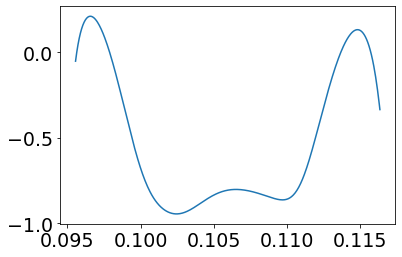

In [ ]:
plt.plot(freqs, np.log10(R))

(array([ 40., -40.,   1.]), array([[ 66.66666667, -66.66666667,   0.        ],
        [-66.66666667, 466.66666667,   0.        ],
        [  0.        ,   0.        ,   0.        ]]))

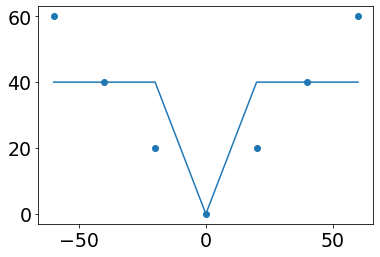

In [ ]:
x = np.array([-3, -2, -1, 0, 1, 2, 3])*20
y = np.abs(x)

model = lambda x, a, b, c: np.array([a+b*(np.abs(u)<c) for u in x])
fit=scipy.optimize.curve_fit(
    model,
    #freqs, R,     #Using R with proper weighing doesn't converge at all
    x, y, 
    method = 'dogbox',
    #p0 = [freqM, dfreqM, 0, -5],
    #sigma = 1/R    # Log weighing
    )

plt.scatter(x,y)
plt.plot(x,model(x,*fit[0]))
fit

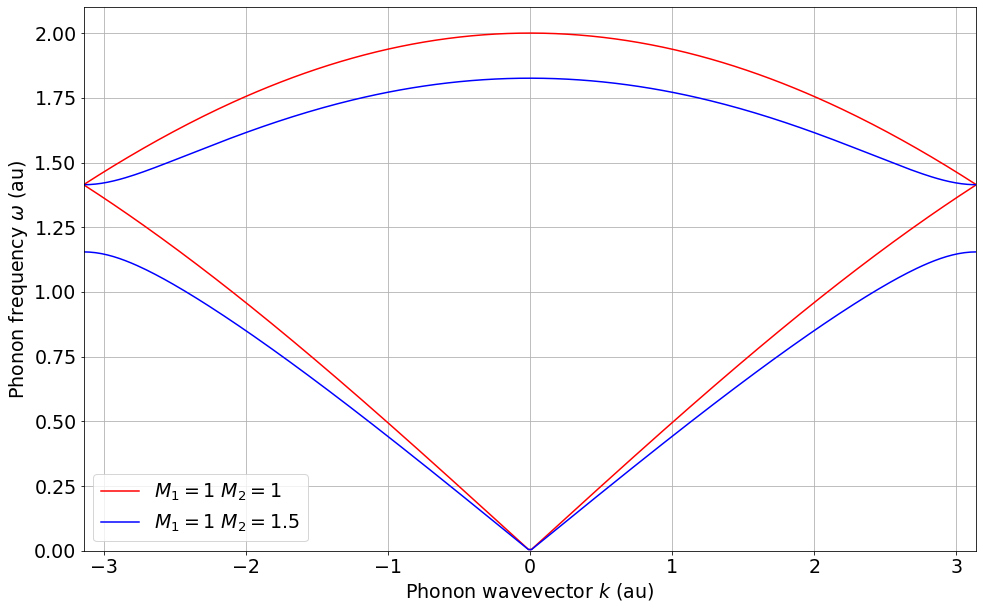

In [ ]:
# Extra: dispersion relation of a diatomic linear chain
plt.figure(figsize=[16,10])
ax = plt.axes()


k = np.linspace(-np.pi, np.pi, 300)
plt.xlim(min(k), max(k))

M1 = 1
M2 = 1
w = np.sqrt(1/M1/M2*(M1+M2+np.sqrt(M1**2+M2**2+2*M1*M2*np.cos(k))))
plt.plot(k, w, color = "r", label = r"$M_1=1$ $M_2=1$")
w = np.sqrt(1/M1/M2*(M1+M2-np.sqrt(M1**2+M2**2+2*M1*M2*np.cos(k))))
plt.plot(k, w, color = "r")

M2 = 1.5
w = np.sqrt(1/M1/M2*(M1+M2+np.sqrt(M1**2+M2**2+2*M1*M2*np.cos(k))))
plt.plot(k, w, color = "b", label = r"$M_1=1$ $M_2=1.5$")
w = np.sqrt(1/M1/M2*(M1+M2-np.sqrt(M1**2+M2**2+2*M1*M2*np.cos(k))))
plt.plot(k, w, color = "b")
plt.grid()
plt.legend()
plt.ylim(0,2.1)

plt.xlabel(r"Phonon wavevector $k$ (au)")
plt.ylabel(r"Phonon frequency $\omega$ (au)")
plt.savefig("DiatomicChain.svg", format = "svg", bbox_inches='tight')

plt.show()